# Experimental environment setup

## Library preparation

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import time, os, io
from PIL import ImageGrab
from IPython.display import Image, display
import clipboard
from scipy import stats
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

import sys 
sys.path.append('..')
from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


In [3]:
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
from qcodes.instrument_drivers.tektronix.AWG3252_Isrc import AWG3252_Isrc
from qcodes.instrument_drivers.HP.HP34401 import HP34401
from qcodes.instrument_drivers.HP.HP34401_DL1201 import HP34401_DL1201
from qcodes.instrument_drivers.Keithley.Keithley_2600_channels import *
from qcodes.instrument_drivers.tektronix.AWG5204_Isrc import AWG5204_Isrc

In [4]:
# #This code saves the image sources in clipboard into png file and copy a short PY code back into clipboard to display the specific png file. 

# import time, os
# dir_path = os.getcwd()
# pngpath = dir_path+"\\img\\{}{}{}-{}{}{}.png".format(time.localtime()[0]%100,time.localtime()[1],time.localtime()[2],time.localtime()[3],time.localtime()[4],time.localtime()[5])

# from PIL import ImageGrab
# img = ImageGrab.grabclipboard()
# img.save(pngpath, 'PNG')

# from IPython.display import Image, display
# display(Image(filename=pngpath))

# import clipboard
# clipboard.copy('display(Image(filename=r\'{}\'))'.format(pngpath))

In [5]:
# display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\measDC\55B1_revist 1D chain\img\19113-124446.png'))

## Instrument nicknames and QC database initialization

In [6]:
try:
   Instrument.close_all()
except KeyError:
   pass    
except NameError:
   pass 

K2602 =  Keithley_2600(name = 'K2602', address = "GPIB::26::INSTR" )
Flux_chA = K2602.smua.curr
Flux_chB = K2602.smub.curr
Bfield =  Flux_chA
Bfield.step = .1e-3
Bfield.inter_delay = .1

LS370 = Model_372(name = 'LS370 input Ch', address = 'GPIB::12::INSTR', terminator='\n')
T8 = LS370.ch08.temperature

# htr = LS370.sample_heater
htr = LS370htr()
htr.Tset(0.030)
htr.PIDset(30,5,1)
htr.HTRset('off')

# Isrc = AWG5204_Isrc('gen', 'TCPIP0::AWG52000-XXXX::inst0::INSTR', ch = 1, R_bias = 1e9, Attn = 1, timeout = 20)
Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR',  R_bias = 1e9, Attn = 1)
Isrc.init()

Vmeter = HP34401_DL1201('meter', 'GPIB0::8::INSTR', Gain = 100)
Vmeter.init('fast 6')

station = qc.Station(Isrc, Vmeter)

print ('Instrument initialization completed.')

Connected to: Keithley Instruments Inc. 2602A (serial:1272049, firmware:2.1.5) in 0.48s
Connected to: LSCI 370 (serial:370665, firmware:04102008) in 0.10s
initialization \\JOSH-PC\Gersh_Labview\DC measurement\LSCI 370 PYTHON_conf.vi
Instrument initialization completed.


## Fridge handling log

In [7]:
# action = 'User: wsLu. Sample: {}. Roughing'.format(SAMPLE)
# action = 'ON Turbo @P1 = 6.47E-2'
# action = 'ON PT @P1 = 8.26E-4. ON HS-STILL, HS-MC'
# action = 'Test Cyro eff., t1hr @P1 = 3.51E-6'
# action = 'Add exchange gas thru v3'
# action = 'Pump coldtrap to P6 = 1.89E-1'
# action = 'Start Pulse_PreCool @T8 = 11.56K'
# action = 'Start Condense_wLN2'
action = 'base T'
# action = 'Warm up to RT'

Tlst = [48, 3.7, 0.661, 0.030, 0.80]
# Tlst = ['dont care']
flow = '0.20'
stillOut = '0'

tAbrStr = time.asctime()
actionStr = '\n\t'+action+'\n'
TPstr = '\tT[1,2,5,6,8]:\t{}\n'.format(Tlst)
misc = '\tFlow = {}, \tStill = {}%\n\n'.format(flow, stillOut)
clipboard.copy(tAbrStr+actionStr+TPstr+misc)

T8.get()

14.748

Fri Nov  22 10:55:00 2019
	Start Pulse_PreCool @T8 = 13K
	T[1,2,5,6,8]:	[55.9, 5.0, 7.1, 9.8, 13]
	Flow = 0.00, 	Still = 0%

Fri Nov  22 08:55:00 2019
	Start Pulse_PreCool @T8 = 11.56K
	T[1,2,5,6,8]:	[49.6, 4.3, 5.0, 6.5, 8.9]
	Flow = 0.00, 	Still = 0%

Wed Nov  20 22:35:00 2019
	ON PT @P1 = 2.30E-3. ON HS-STILL, HS-MC
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%

Wed Nov  20 21:20:00 2019
	ON Turbo @P1 = 3.0E-3
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%

Wed Nov  20 22:35:00 2019
	User: wsLu. Sample: Q1D074, SiOx002. Roughing
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%



## Scripts

### Measurement scripts

In [8]:
def uduFF_list(amp1=240e-12, amp2=2000e-12, stp1=2e-12, stp2=80e-12):

    i_list_uf = np.linspace(0, amp1, round (amp1/stp1) + 1)
    i_list_uc = np.linspace(amp1, amp2, round ((amp2-amp1)/stp2) + 1)
    i_list = np.append(i_list_uf, i_list_uc)

    i_list_d = [np.linspace(amp2, amp1, round ((amp2-amp1)/stp2) + 1),
                np.linspace(amp1, 0, round (amp1/stp1) + 1),
                np.linspace(0, -1*amp1, round (amp1/stp1) + 1),
                np.linspace(-1*amp1, -1*amp2, round ((amp2-amp1)/stp2) + 1)]
    for lst in i_list_d:
        i_list = np.append(i_list, lst)

    i_list_ucn = np.linspace(-1*amp2, -1*amp1, round ((amp2-amp1)/stp2) + 1)
    i_list_ufn = np.linspace(-1*amp1, 0, round (amp1/stp1) + 1)
    i_list = np.append(i_list, i_list_ucn)
    i_list = np.append(i_list, i_list_ufn)

    return i_list

In [9]:
def setup():
    Isrc.I.set(0)

def cleanup():
    Isrc.I.set(0) 
    Bfield.set(0)

In [10]:
def IVC_udu (amp, stp, Gain, R_bias, Attn, tfsstb = 0.1):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    
    i_list = udu_list(amp, stp)
    ti_list = tqdm_notebook(i_list)

    name_exp(sample = SAMPLE, exp_type = 'IVc @T={}K, B={}A'.format(si_format(T8.get()), si_format(Bfield.get(), precision = 3)))
    with meas.run() as datasaver:
        for i in ti_list:
            
            Isrc.I.set(i)
            time.sleep(tfsstb)
            V = Vmeter.V.get()

            res = [( Isrc.I, i ), ( Vmeter.V, V )]
            datasaver.add_result(*res) 

    cleanup()
    return datasaver.run_id 

In [11]:
def Bperiod_meas (amp=1e-9, Gain=100, R_bias=1e9, Attn=1, B_list = [0]):

    meas = set_meas(Vmeter.V, Bfield, setup = setup, cleanup = cleanup)
    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    tB_list = tqdm_notebook(B_list)

    name_exp(sample = SAMPLE, exp_type = 'B periodicity @T={}K, Ib={}A'.format(si_format(T8.get()), si_format(amp, precision=0)))
    with meas.run() as datasaver:

        Isrc.I.set(amp)
        for B in tB_list:

            Bfield.set(B)
            time.sleep(0.5)
            V = Vmeter.V.get()
            volt = [( Bfield, B ), ( Vmeter.V, V )]

            datasaver.add_result(*volt) 

    cleanup()
    return datasaver.run_id 

In [12]:
def Ic_meas (amp, stp, thr, Gain, R_bias, Attn, tfsstb = 0.1):

    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)
    Vmeter.set_Gain (Gain) 
    Isrc.set_R_Attn (R_bias, Attn)
    
    i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
    ti_list_u = tqdm_notebook(i_list_u)
    i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)    
    ti_list_d = tqdm_notebook(i_list_d)
    ti_lists = [ ti_list_u ,  ti_list_d]
    
    name_exp(sample = SAMPLE, exp_type = 'sc branch @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision = 3)))
    with meas.run() as datasaver:
        for ti_list in ti_lists:
            
            Isrc.I.set(0)
            V_ = Vmeter.V.get()            
            time.sleep(1)
            
            for i in ti_list:
            
                Isrc.I.set(i)
                time.sleep(tfsstb)

                V = Vmeter.V.get()
                dV = V - V_
                V_ = V 
                
                if (abs(dV) > thr)  or (abs(V) > 4e-3 ) : #
                    break

                res = [( Isrc.I, i ), ( Vmeter.V, V )]
                datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

In [13]:
def IVcB_meas (i_list, B_list, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1):

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    i_lists = [i_list]
    
    meas = set_meas(Vmeter.V, Isrc.I,setup = setup, cleanup = cleanup)
    tB_list = tqdm_notebook(B_list)
    for B in tB_list:

        name_exp(sample = SAMPLE, exp_type = 'full IVc(B) @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision =3)))
        with meas.run() as datasaver:

            Bfield.set(B)
            for i_list in i_lists:

                Isrc.I.set(0)
                V_ = Vmeter.V.get()
                time.sleep(1)

                for i in i_list:

                    Isrc.I.set(i)
                    time.sleep(tfsstb)

                    V = Vmeter.V.get()
                    dV = V - V_
                    V_ = V

                    if  (abs(V) > 6.4e-3) : #(abs(dV) > thr)  or
                        break
                            

                    res = [( Isrc.I, i ), ( Vmeter.V, V )]
                    datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

In [14]:
# adaptive step size with while loop
def IVcB_ada(npts_B = 51, tfsstb = 0.1):
    ZF =  0.004e-3
    FF =  0.224e-3
    dF =  0.250e-3
    midF = 0.154e-3

    maxI = 3e-9
    step_ff = 2e-12
    step_f = 10e-12
    step_c = 200e-12

    thr = 3e-3

    B_list = np.linspace(ZF, ZF + 1.0*dF, npts_B)
    tB_list = tqdm_notebook(B_list)

    Vmeter.set_Gain (Gain = 100) 
    Isrc.set_R_Attn (R_bias = 1e9, Attn=1)

    for B in tB_list:
        meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

        name_exp(sample = SAMPLE, exp_type = 'Bscan IVC @T ={:2.1f}mK, B = {}A'.format(T8.get()/1e-3, si_format(B)) )  
        with meas.run() as datasaver:

                Bfield.set(B)

                for pm in [1, -1]:

                    i = 22.5e-12

                    Isrc.I.set(i)
                    time.sleep(1)
                    V_off = Vmeter.V.get()
                    V_ = V_off
                    time.sleep(1)

                    if B < midF:
                        step = step_f
                    else:
                        step = step_ff

                    while abs(i) < maxI:

                        Isrc.I.set(i)
                        time.sleep(tfsstb)

                        V = Vmeter.V.get()
                        dV = V - V_
                        V_ = V

                        res = [( Isrc.I, i - 22.5e-12 ), ( Vmeter.V, V  )]

                        datasaver.add_result(*res) 

                        if (abs(dV) > thr)  or (abs(V - V_off) > 4e-3 ) : #
                            step = step_c

                        i += pm*step

    cleanup()
    return datasaver.run_id 

In [15]:
# # Use this code for T-dependent tasks
# # Using PID 30,5,1 & htr range 10mA for T8 upto 550mK
# setT8_lst = np.linspace(0.290, 0.550, 1+3*5+1-3) 

# tolerT8 = 0.02
# chkrepeat = 20
# chkperiod_sec = 2

# Tnow_alllst = []
# timer_lst = []

# for setT8 in setT8_lst:
# #     htr.setpoint(setT8)
#     htr.Tset(setT8)
#     print('ramping T8 to {}K...'.format(si_format(setT8)))
#     time.sleep(30)
#     Tnow_lst = []

#     t0 = time.time()
#     count_T = 0
#     while count_T < chkrepeat:
#         T_now = T8.get()
#         if (1-tolerT8)*setT8 <= T_now <= (1+tolerT8)*setT8 :
#             count_T +=1
#             Tnow_lst.append(T_now)
#             time.sleep(chkperiod_sec)
#         elif count_T >= 1 :
#             count_T -=1
#     t1 = time.time()
    
#     timer_lst.append(t1-t0)
#     Tnow_alllst.append(Tnow_lst)

#     IVcB_ada(51) # insert here the repeatative work to be done at each T

# # htr.setpoint(0.030)
# htr.Tset(0.030)

In [16]:
def RTc (dataPts = 100, Gain = 100, R_bias = 1e9, Attn = 1, tfsstb = 0.1, I_bias = 0.4e-9, T_str = 0):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    pts_list = np.arange(1, dataPts)
    tpts_list = tqdm_notebook(pts_list)

    name_exp(sample = SAMPLE, exp_type = 'RTc')
    with meas.run() as datasaver:
        for j in tpts_list:

            Ib_list = udu_list(1*I_bias, 0.5*I_bias)
            V1_list = []
            T8_lst = []
            for Ib in Ib_list:
                Isrc.I.set(Ib)
                time.sleep(tfsstb)
                V1_list = np.append(V1_list, Vmeter.V.get())
                T8_lst.append(T8.get())
            T_now = sum(T8_lst)/len(T8_lst)
            R_now, intercept, r_value, p_value, std_err = stats.linregress(Ib_list, V1_list)
            
            res = [( Isrc.I, T_now ), ( Vmeter.V, R_now )]
            with open('CH0 T {}.log'.format(time.strftime('%d-%m-%y', time.localtime())),'a+') as fp:
                fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(R_now), time.localtime())+'\n')
                fp.close
            with open('CH8 T {}.log'.format(time.strftime('%d-%m-%y', time.localtime())),'a+') as fp:
                fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(T_now), time.localtime())+'\n')
                fp.close

#             print('Current T8= {}K'.format(si_format(T8.get()), end='\r'))
            sys.stdout.write("\rCurrent T8= {}K".format(si_format(T8.get())))
            sys.stdout.flush()
            datasaver.add_result(*res)
            if T_str == 300:
                time.sleep(54.5)
            else:
                time.sleep(0.05)

    cleanup()
    return datasaver.run_id 

### Data processing scripts

In [17]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [18]:
def databyid (run_id: int, **kwargs):
    from qcodes.dataset.data_set import load_by_id

    dataset = load_by_id(run_id)
    title = f"#{run_id}, Exp {dataset.exp_name} ({dataset.sample_name})"
    alldata = get_data_by_id(run_id)
    
    return ({'title':title, 'alldata':alldata})

def DFMbyid(run_id: int):
    data = databyid(run_id)
    DTF = {data['alldata'][0][0]['name'] : pd.Series(data['alldata'][0][0]['data'], index = np.arange(len(data['alldata'][0][0]['data']))), 
           data['alldata'][0][1]['name'] : pd.Series(data['alldata'][0][1]['data'], index = np.arange(len(data['alldata'][0][0]['data'])))} 
    DTF = pd.DataFrame(DTF)
    return DTF

def dataread (filename, splitkw = '!DATASTR!'):
    with open(filename,'r') as file:
        rawtxt = file.read()
        splittxt = rawtxt.split(splitkw)    
    return(splittxt)

def filetoDFM (filename):
    datatxt = dataread(filename = filename)
    datastr = io.StringIO(datatxt[1])
    DataFM = pd.read_csv(datastr, sep = '\t')
    DataFM = DataFM.drop(DataFM.index[0])
    DataFM = DataFM.astype(float)
    return(DataFM, datatxt[0])

def pltMaxMin(lst, pMF = 1.1):
    pMin = lst.mean()-pMF*(lst.max()-lst.min())/2
    pMax = lst.mean()+pMF*(lst.max()-lst.min())/2
    pPos = (lst.mean()-lst.min())*pMF+lst.min()
    return(pMin,pMax,pPos)

In [19]:
# # Quick visualization of the results

# qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format('70B1N7')
# initialise_database()
# f,ax=plt.subplots()

# label = ['a',
#          'b',
#          'v',
#          'meas on Nov 11th']

# for i,v in enumerate([105, 971,1092,1095]):
#     data = get_data_by_id(v)
#     Is = data[0][0]['data']
#     Vs = data[0][1]['data']
#     ax.plot(Is, Vs, '.', ls='-',label = '{}'.format(label[i]))

# ax.legend()

## Devices

### Device detail

- ID: Q1D074: large JJ chains
 - N3: (7ba,8ba), $R_{RT, 4pb} = 350k\Omega$, this $.7 \times .7 \mu m^2 JJ$ device has $E_J 180mK, E_C 90mK$
 - N4: (6ab,9ba), $R_{RT, 4pb} = 22.3k\Omega$, this $1.5 \times 1.5 \mu m^2 JJ$ device has high $E_J$ to check $E_J(cos(\phi))$ cross-over.
- ID: SiOx002: pure Al on SiOx for $T_C$ characterization
 - N3: (12ba,11ba), $R_{RT, 4pb} = 52.3\Omega$, $1\mu m$ wide Hall bar. Ch11a was dead right after chamber closed. $R_{3pb}=100.7k\Omega$ doesn't look promising.
 - N4: (1ab,1a2b), $R_{RT, 4pb} = \Omega$, $2\mu m$ wide Hall bar
 - N6: (3ab,4ba), $R_{RT, 4pb} = \Omega$, $10\mu m$ wide Hall bar

- Instrumentation
 - $R_{G, 2pb}$ = OVFL on all devices
 - $R_{coil} = 1.24k\Omega$
 - $R_{therm} = 1.056k\Omega$


- Device scheme for Q1D074
 - Type: 1D chain with 16 SQUIDs, pentagon capacitors with larger spacing to accomodate larger junction area design.
 - Shunting capacitor C0: No Pt yet.
 - C0 area: 
 - SQUID area: 
 - Junction area:
 - Oxidation: ??? torr "wet" oxigen, 10+4min (by Plamen) (A 20x, ox 140x, w>>2.5um x 2.5um)
 
- Device scheme for SiOx002
 - Typical Hall bar with width ranging from $0.2\mu m - 10\mu m$
 - Pure Al by AC sputtering, thk ranging from $20nm - 50nm$

### Biasing scheme

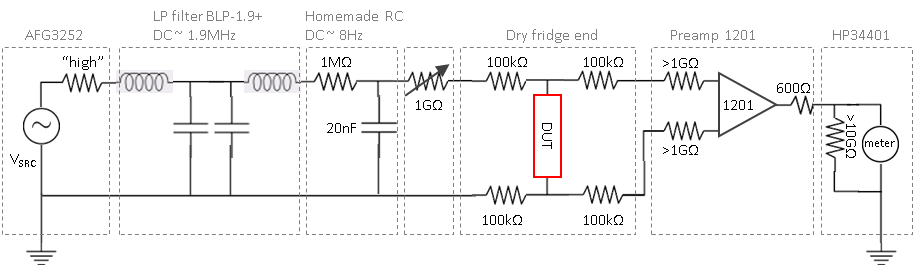

In [20]:
display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\DC meas\img\191026-183349.png'))

### Device quick overview

N3 **(low Z_env)**
RN=165E3/8, JJwidthUM=sqrt(0.2205*.17325), metalTHK=250E-10, Tc=1.34
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [20.625, 0.98947]
[I_AB (nA), EJ (mK)] = [15.51322, 369.78959]
[C_JJQP (fF), EC (mK)] = [1.91008, 486.6938]
[C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
[Freq_plasma (GHz))] = [1.60569]
[Q, Beta, EJ/EC] = [96.4, 9286.2, 184.2]

RRR(RT/10K) = 0.874

In [21]:
# display(Image(filename=r'\\JOSH-PC\OurData_OneDrive\img\70B1\N3.jpg'))

In [22]:
# N3
# qckplt(r'\\JOSH-PC\OurData\wsLu\RawData\DC\191102-70N3_IV300K-124250.txt')

## Measurement

### List of run_ids

In [25]:
# ZF =  0.004e-3
# FF =  0.224e-3
# dF = 0.250e-3
# midF = 0.154e-3


# keys  = ['ids',                  'T',          'B',                                          'Vthr']
# valss = [[range(105, 205+1)[:],   45e-3,       np.linspace(ZF, ZF + 1.1*dF, 101)[:],         4e-3],
#          [range(208, 292+1)[:],   50e-3,       np.linspace(ZF, ZF + 1.1*dF, 101)[:-16],      4e-3]
#          [range(296, 346+1)[:],   70e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            4e-3],
#          [range(347, 397+1)[:],   90e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            4e-3],
#          [range(398, 448+1)[:],  110e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            4e-3],
#          [range(450, 500+1)[:],  110e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
#          [range(501, 551+1)[:],  130e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
#          [range(552, 602+1)[:],  150e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
#          [range(603, 653+1)[:],  170e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
#          [range(654, 704+1)[:],  190e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
#          [range(705, 755+1)[:],  210e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
#          [range(758, 808+1)[:],  230e-3,       np.linspace(ZF, ZF + 1.0*dF, 51) ,            3e-3],
         

#         ]  
        

# exps = [{ key : val for key, val in zip(keys, vals)  }  for vals in valss ]

### Plans and list of ToDo-es

**Plan**
- Meas $T_C$ for pure Al HB: O2N4($2\mu m$), O2N6($10\mu m$). O2N3 probably can't get SC state by all means.
- Meas $I_C$ for 74N3


**Selected meas to be done**
- 
- 

## Experiments

In [26]:
SAMPLE = 'O2N4'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

In [171]:
IVC_udu (amp=1e-9, stp=100e-12, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1)

Starting experimental run with id: 2



2

In [ ]:
RTc(dataPts = 1e5, Gain = 100, R_bias = 2.2e6, Attn = 1, tfsstb = 0.1, I_bias = 0.4e-6, T_str = 0)

Starting experimental run with id: 21
Current T8= 3.2 KK

## Key observations

<IPython.core.display.Javascript object>


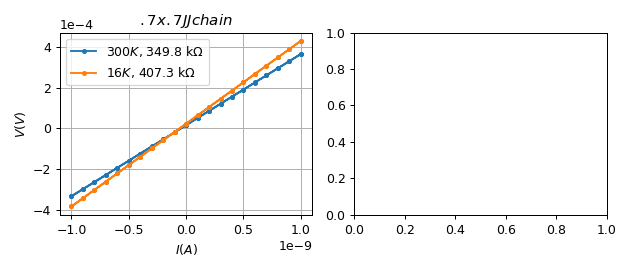

In [172]:
SAMPLE = '74N3' #7ba,8ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$300K$',
          '$16K$']
for i,v in enumerate([1,2]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('$.7x.7 JJ chain$')
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

# labelR = [#'from 300K',
#           'warm up',
#           'cool down, $T_C = 1.95K$']
# for i,v in enumerate([1,2]):
#     data = get_data_by_id(v)
#     T = data[0][0]['data']
#     R = data[0][1]['data']
#     Rs = R*devW/devL
#     ax[1].plot(T, Rs, '.', label = labelR[i], color = 'C{}'.format(1-i))#ls='-', alpha=1-0.99*i 

# ax[1].legend()
# ax[1].set_xlabel('$T_8 (K)$')
# ax[1].set_ylabel('$R_s (\Omega/sq)$')
# ax[1].title.set_text('RTc for 6bN8, Hallbar-Dow')
# ax[1].set_ylim(-25,175)
# ax[1].grid()
# ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


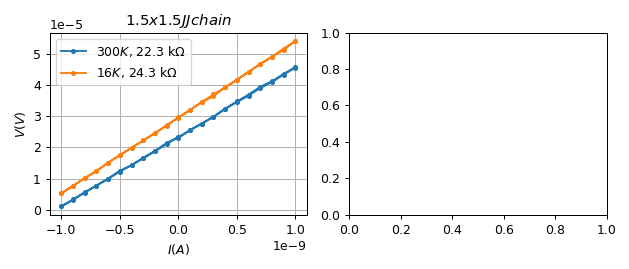

In [169]:
SAMPLE = '74N4' #6ab,9ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 1.51e-6, 17.9e-6, 40e-9

labelL = ['$300K$',
          '$16K$']
for i,v in enumerate([1,2]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('$1.5x1.5 JJ chain$')
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

# labelR = [#'from 300K',
#           'warm up',
#           'cool down, $T_C = 1.95K$']
# for i,v in enumerate([1,2]):
#     data = get_data_by_id(v)
#     T = data[0][0]['data']
#     R = data[0][1]['data']
#     Rs = R*devW/devL
#     ax[1].plot(T, Rs, '.', label = labelR[i], color = 'C{}'.format(1-i))#ls='-', alpha=1-0.99*i 

# ax[1].legend()
# ax[1].set_xlabel('$T_8 (K)$')
# ax[1].set_ylabel('$R_s (\Omega/sq)$')
# ax[1].title.set_text('RTc for 6bN8, Hallbar-Dow')
# ax[1].set_ylim(-25,175)
# ax[1].grid()
# ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


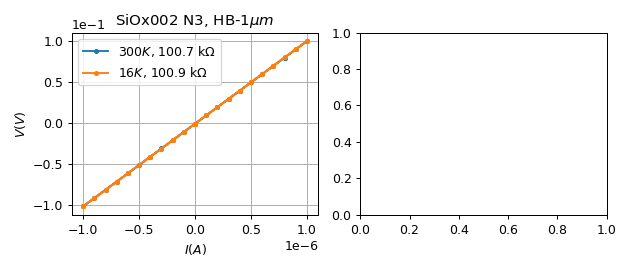

In [166]:
SAMPLE = 'O2N3' #12ba,11b12a
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 1.51e-6, 17.9e-6, 40e-9

#'$1\mu A$', runid=2, before ch11b was dead
labelL = ['$300K$',
          '$16K$']
for i,v in enumerate([6,7]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('SiOx002 N3, HB-$1\mu m$')
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

# labelR = [#'from 300K',
#           'warm up',
#           'cool down, $T_C = 1.95K$']
# for i,v in enumerate([1,2]):
#     data = get_data_by_id(v)
#     T = data[0][0]['data']
#     R = data[0][1]['data']
#     Rs = R*devW/devL
#     ax[1].plot(T, Rs, '.', label = labelR[i], color = 'C{}'.format(1-i))#ls='-', alpha=1-0.99*i 

# ax[1].legend()
# ax[1].set_xlabel('$T_8 (K)$')
# ax[1].set_ylabel('$R_s (\Omega/sq)$')
# ax[1].title.set_text('RTc for 6bN8, Hallbar-Dow')
# ax[1].set_ylim(-25,175)
# ax[1].grid()
# ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


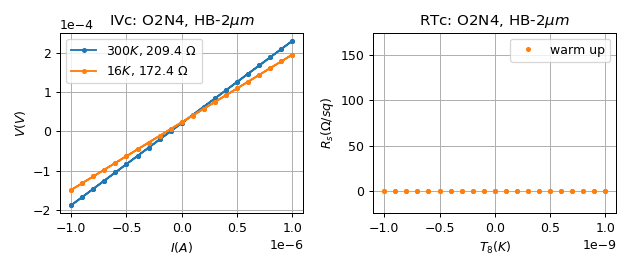

In [160]:
SAMPLE = 'O2N4' #1ab,1a2b
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 3.06e-6, 12.2e-6, 48e-9

labelL = ['$300K$',#8
          '$16K$']
for i,v in enumerate([8,20]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('IVc: O2N4, HB-$2\mu m$')
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelR = ['cool down, $T_C = 1.95K$',
          '']
for i,v in enumerate([21]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i], color = 'C{}'.format(1-i))#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc: O2N4, HB-$2\mu m$')
ax[1].set_ylim(-25,175)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


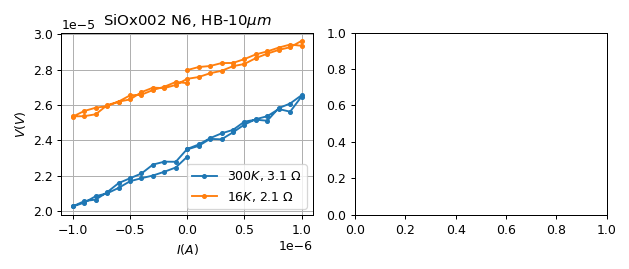

In [163]:
SAMPLE = 'O2N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 12.3e-6, 11.9e-6, 56e-9

labelL = ['$300K$',
          '$16K$']
for i,v in enumerate([4,6]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('SiOx002 N6, HB-$10\mu m$')
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

# labelR = [#'from 300K',
#           'warm up',
#           'cool down, $T_C = 1.95K$']
# for i,v in enumerate([1,2]):
#     data = get_data_by_id(v)
#     T = data[0][0]['data']
#     R = data[0][1]['data']
#     Rs = R*devW/devL
#     ax[1].plot(T, Rs, '.', label = labelR[i], color = 'C{}'.format(1-i))#ls='-', alpha=1-0.99*i 

# ax[1].legend()
# ax[1].set_xlabel('$T_8 (K)$')
# ax[1].set_ylabel('$R_s (\Omega/sq)$')
# ax[1].title.set_text('RTc for 6bN8, Hallbar-Dow')
# ax[1].set_ylim(-25,175)
# ax[1].grid()
# ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

## Brief summary